In [11]:
library(tidyverse); library(dplyr)
theme_set(theme_bw())

In [12]:
start_date <- as.Date("2022-05-01")
start_date <- as.Date("2022-05-07")

In [13]:
###1. Data
read.csv("../data/input.csv") -> df_input
df_input$date <- as.Date(df_input$date)
df_input$date_import <- as.Date(df_input$date_import)

(censor_import <- max(df_input$date))

df_input %>% filter(!region %in% c("Europe")) %>% rename(censor=censoring, country=location) %>%
mutate(date_imp=case_when(censor==1~censor_import, censor==0~date_import)) %>%
dplyr::select(date, country, F_i, date_imp, censor) %>% filter(date >= start_date) -> df_input

[1] "2022-10-03"

In [15]:
###2. Likelihood -----
## likelihood for country i 
LogL_i <- function(data, country_i){
    data_i <- data %>% filter(country==country_i)
    date_start_i <- data_i[1,1]
    date_import_i <- data_i[length(data_i[,1]), 4]
    surv_days_i <- as.numeric(date_import_i - date_start_i)+1
    F_i_vec <- data_i$F_i
    cens_i <- data_i[1,5] 
    
    function(alpha){
        return(
            (1-cens_i) * (log(alpha * F_i_vec[surv_days_i]) + (-sum(alpha * F_i_vec[1:surv_days_i]))) + 
            cens_i * (-sum(alpha * F_i_vec[1:surv_days_i])) 
        )
    }
}

In [16]:
###3. MLE
## full likelihood
LogL_full <- function(data, country_list){
  function(alpha){
    return(sum(sapply(country_list, FUN = function(x){LogL_i(data=data, country_i = x)(alpha=alpha)})))
  }
}

## excluding the endemic countries (along with the UK)
df_input %>% 
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana",
                        "United Kingdom"))) -> df_input_temp

## specifying the data for the likelihood
data_llk <- df_input_temp

## MLE
options(warn=-1)
(optim(fn=LogL_full(data=data_llk, country_list=(unique(data_llk$country))), 
       par=c(1), method="Brent", lower=(0), upper=(1000),
       control = list(fnscale = -1, maxit=1000000)) -> est_result)
options(warn=0)

$par
[1] 0.0004631028

$value
[1] -323.3209

$counts
function gradient 
      NA       NA 

$convergence
[1] 0

$message
NULL

In [17]:
## 95% confidence intervals
(readRDS("est_llk.rds") -> est_llk)

# ci_pro <- matrix(NA, ncol=2, nrow=1)
# CI <- function(par_CI){return(2*(LogL_full(data=data_llk, country_list=(unique(data_llk$country)))(par_CI)-
#                                  est_result$value))} #llk

# par_CI <- seq(0.0000001, 0.001, by = 0.00001)
# logLik <- sapply(par_CI, FUN = CI)
# as.data.frame(par_CI) -> par_CI; as.data.frame(logLik) -> logLik

# cbind(par_CI, logLik) -> data_CI
# data_CI$logLik[data_CI$logLik<(max(data_CI$logLik)-3.84)] <- NA
# data_CI %>% na.omit() -> data_CI

# min(data_CI$par_CI) -> ci_pro[1,1]; max(data_CI$par_CI) -> ci_pro[1,2]
# colnames(ci_pro) <- c("lower","upper")

# saveRDS(ci_pro, "ci_pro.rds")
# saveRDS(est_result$value, "est_llk.rds")

[1] -523.8481

In [18]:
(readRDS("ci_pro.rds") -> ci_pro)

lower,upper
0.0005001,0.0007401


In [19]:
###4. Fitting result
df_input %>% filter(censor==0) -> df_case
sort(unique(df_case$country)) -> country_list

Survf_i <- list()
for(i in 1:length(country_list)){
    
    data_i <- df_case %>% filter(country==country_list[i])
    date_start <- min(data_i$date)
    date_end <- max(data_i$date)
    date_import_i <- data_i[length(data_i[,1]), 4]
    surv_days_i <- as.numeric(date_import_i - date_start)+1

    surv <- rep(0,(as.numeric(date_end-date_start)+1))
    for(t in 1:(as.numeric(date_end-date_start)+1)){
        surv[t] <- exp(-sum(est_result$par*data_i$F_i[1:t]))
    }
    surv -> Survf_i[[i]]
}

In [20]:
do.call("rbind", Survf_i) -> Survf_all
cbind(as.data.frame(country_list), Survf_all) %>% rename(country=country_list) -> Survf_all

df_case %>% filter(date==min(df_case$date)) %>% mutate(date_imp_num=as.numeric(date_imp - date)+1) %>% 
dplyr::select(country, date_imp_num) -> temp

merge(temp, Survf_all, by=c("country"), all.y=TRUE) %>% gather(3:152, key='day', value='value') -> Survf_all_fig
Survf_all_fig$day <- as.numeric(Survf_all_fig$day)

In [21]:
## list of countries touching 0
Survf_all_fig %>% filter(day==max(Survf_all_fig$day)) %>% filter(value <= 0.025) %>% dplyr::select(country) -> temp
country_list0 = temp[['country']]

## calculating quantiles
quan_list0 <- list()
for(k in 1:length(country_list0)){
    Survf_all_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.975)==min(abs(value-0.975))) %>%
    mutate(quan=c("q975")) -> q_975
    Survf_all_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.75)==min(abs(value-0.75))) %>%
    mutate(quan=c("q75")) -> q_75
    Survf_all_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.5)==min(abs(value-0.5))) %>%
    mutate(quan=c("q5")) -> q_5
    Survf_all_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.25)==min(abs(value-0.25))) %>%
    mutate(quan=c("q25")) -> q_25
    Survf_all_fig %>% filter(country==country_list0[k]) %>% filter(abs(value-0.025)==min(abs(value-0.025))) %>%
    mutate(quan=c("q025")) -> q_025
    rbind(q_975, q_75, q_5, q_25, q_025) -> quan_list0[[k]]
}
do.call(rbind, quan_list0) -> result_quan_list0

result_quan_list0 %>% mutate(date=day+start_date-1) %>% dplyr::select(-c(value, day)) %>% 
spread(key=quan,value=date) -> quan_list0_fig

In [22]:
## list of countries not toching 0
Survf_all_fig %>% filter(day==max(Survf_all_fig$day)) %>% filter(value > 0.025) %>% dplyr::select(country) -> temp
country_list_non = temp[['country']]

## calculating quantiles
quan_list <- list()
for(g in 1:length(country_list_non)){
    Survf_all_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.975)==min(abs(value-0.975))) %>%
    mutate(quan=c("q975")) -> q_975
    Survf_all_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.75)==min(abs(value-0.75))) %>%
    mutate(quan=c("q75")) -> q_75
    Survf_all_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.5)==min(abs(value-0.5))) %>%
    mutate(quan=c("q5")) -> q_5
    Survf_all_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.25)==min(abs(value-0.25))) %>%
    mutate(quan=c("q25")) -> q_25
    Survf_all_fig %>% filter(country==country_list_non[g]) %>% filter(abs(value-0.025)==min(abs(value-0.025))) %>%
    mutate(quan=c("q025")) -> q_025

    rbind(q_975, q_75, q_5, q_25, q_025) -> temp_quan

    Survf_all_fig %>% filter(country==country_list_non[g]) -> temp

    if(min(temp$value) >= 0.25 && min(temp$value) < 0.5){
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), 
                                             quan==c("q25")~min(temp$value), 
                                             TRUE~value)) -> quan_list[[g]]
    } else if(min(temp$value) >= 0.5 && min(temp$value) < 0.75){
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), 
                                             quan==c("q25")~min(temp$value),
                                             quan==c("q5")~min(temp$value), 
                                             TRUE~value)) -> quan_list[[g]]
    } else if(min(temp$value) >= 0.75 && min(temp$value) < 0.975){
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), 
                                             quan==c("q25")~min(temp$value),
                                             quan==c("q5")~min(temp$value),
                                             quan==c("q75")~min(temp$value), 
                                             TRUE~value)) -> quan_list[[g]]
    } else if(min(temp$value) >= 0.975){
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), 
                                             quan==c("q25")~min(temp$value),
                                             quan==c("q5")~min(temp$value),
                                             quan==c("q75")~min(temp$value), 
                                             quan==c("q975")~min(temp$value), 
                                             TRUE~value)) -> quan_list[[g]]
    } else{
        temp_quan %>% mutate(value=case_when(quan==c("q025")~min(temp$value), TRUE~value)) -> quan_list[[g]]}
}
        
do.call(rbind, quan_list) -> result_quan_list

result_quan_list %>% mutate(date=day+start_date-1) %>% dplyr::select(-c(value, day)) %>% 
spread(key=quan,value=date) -> quan_list_fig

In [23]:
rbind(quan_list0_fig, quan_list_fig) -> quan_list_all

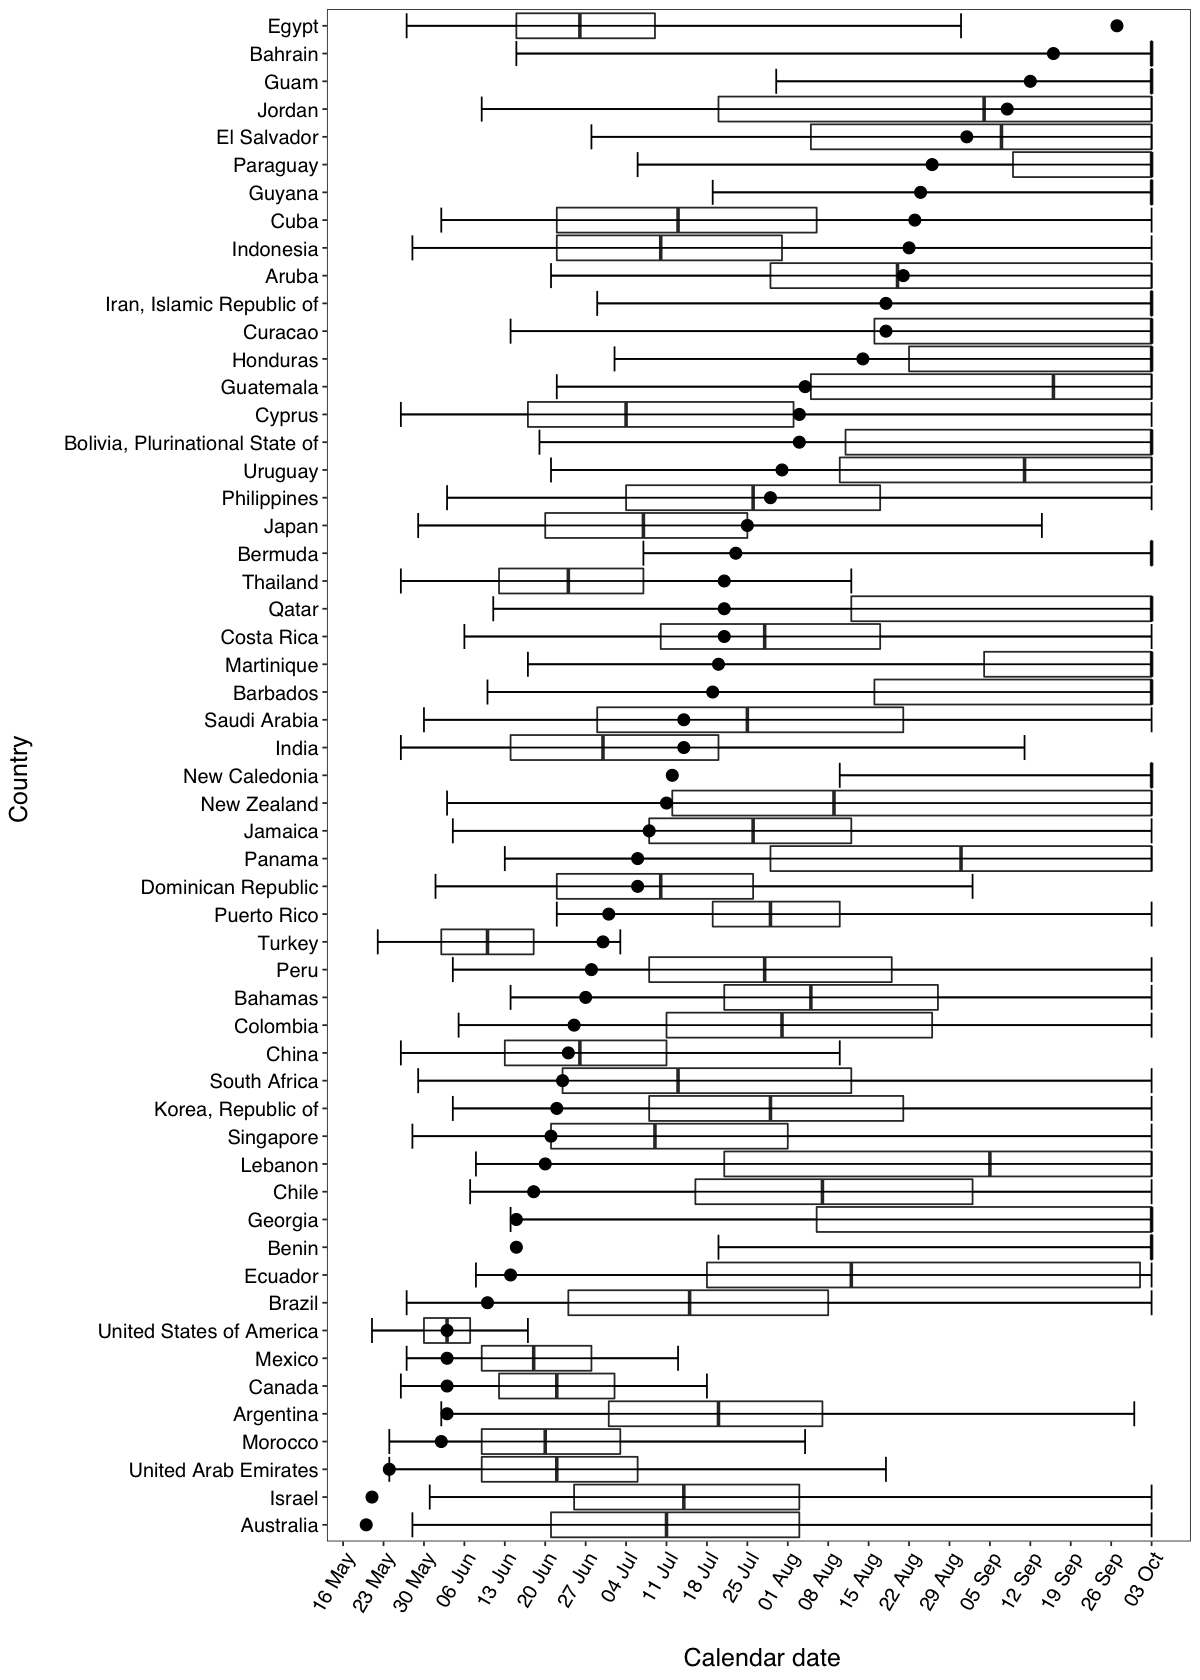

In [28]:
## fitting result
options(repr.plot.width=10,repr.plot.height=14)

# result_quan_list0 %>% mutate(date_imp=date_imp_num+start_date-1) %>% 
# dplyr::select(country, date_imp) %>% distinct() -> quan_imp_list0

Survf_all_fig %>% mutate(date_imp=date_imp_num+start_date-1) %>% 
dplyr::select(country, date_imp) %>% distinct() %>% arrange(date_imp) -> quan_imp_list0

quan_list_all %>% arrange(date_imp_num) %>% 
filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                        "Congo","Congo, Democratic Republic of the","Ghana","United Kingdom"))) %>%
ggplot() +
geom_boxplot(aes(x = reorder(country,date_imp_num), ymin = q025, lower = q25, middle = q5, upper = q75, ymax = q975), 
             stat = "identity") +
geom_errorbar(aes(x = reorder(country,date_imp_num), ymin = q025, ymax = q975)) +
geom_point(data=quan_imp_list0 %>%
           filter(!(country %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                                   "Congo","Congo, Democratic Republic of the","Ghana","United Kingdom"))), 
           aes(x=reorder(country,date_imp), y=date_imp), size=3) +
labs(x="Country \n", y="\n Calendar date") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.position="none",
      plot.title = element_text(size=18, family="sans",color="black"),
      axis.text.x=element_text(angle=60, hjust=1)) +
scale_y_date(date_labels = "%d %b", date_breaks = "1 weeks") +
coord_flip(xlim = NULL, ylim = NULL, expand = TRUE, clip = "on")

ggsave("fitting_woEu.png", width = 10, height = 14)

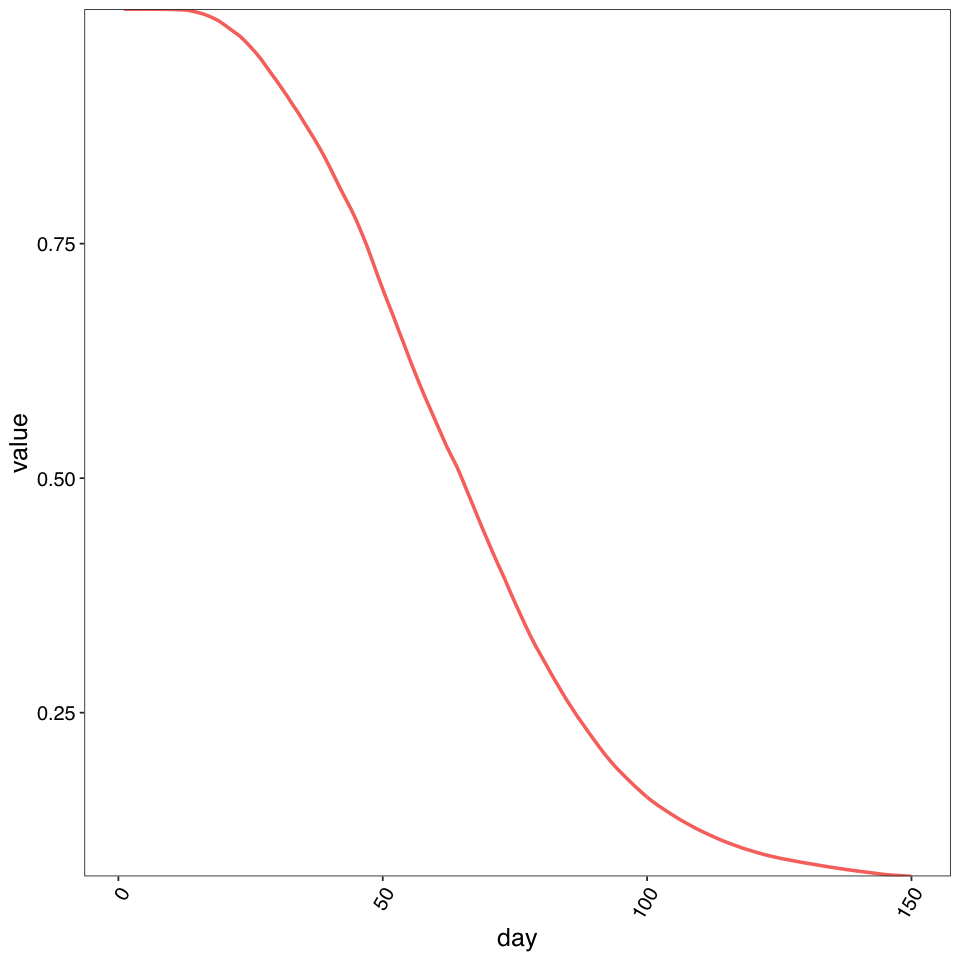

In [25]:
options(repr.plot.width=8,repr.plot.height=8)
Survf_all_fig %>% filter(country==c("Indonesia")) %>%
ggplot() +
geom_line(aes(x=day, y=value, group=country, colour=country), size=1) +
# geom_point(aes(x=day, y=date_imp_num, group=country, colour=country), size=1) +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.position="none",
#       legend.title = element_text(size = 13),
#       legend.text = element_text(size = 13),
      plot.title = element_text(size=18, family="sans",color="black"),
      axis.text.x=element_text(angle=60, hjust=1)) +
scale_y_continuous(expand = c(0, 0))